# 1. Fitting Ne lines in a loop
- This notebook shows how to fit all lines in a folder defined by path
- You tweak the fit for a single line, and then use this to fit all lines. You can then refit lines with high residuals/offsets differing from the rest

## Downloading locally
- You can install DiadFit through PyPI, simply uncomment this line. You only need to run this once per computer (until you want to get an upgraded version)

In [1]:
#!pip install DiadFit --upgrade 

## Now import the packages you need
- When you communicate bugs with Penny, make sure you specify the version here.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
pf.__version__

'0.0.43'

##  Specifying paths
- Put your path here, e.g. where in your computer the spectra and metadata are saved

In [3]:
import os
DayFolder=os.getcwd()
meta_path=DayFolder 
spectra_path=DayFolder
filetype='HORIBA_txt'

In [4]:
Ne_files=pf.get_files(path=spectra_path,
file_ext='txt', ID_str='Ne', 
exclude_str=['diad'], sort=False)

Ne_files

['Ne7_01.txt',
 'Ne1_01.txt',
 'Ne2_01.txt',
 'Ne2_02.txt',
 'Ne2_03.txt',
 'Ne2_04.txt',
 'Ne2_05.txt',
 'Ne2_06.txt',
 'Ne3_01.txt',
 'Ne4_01.txt',
 'Ne5_01.txt',
 'Ne6_01.txt']

### Get Ne line positions for your specific laser wavelength
- At the moment, this returns any Ne lines with intensity >2000 in the NIST databook, although you can change this!

In [5]:
wavelength =532.1 # Specify the specific wavelength of your laser 
df_Ne=pf.calculate_Ne_line_positions(wavelength=wavelength, 
cut_off_intensity=2000)
df_Ne.head()

,Raman_shift (cm-1),Intensity,Ne emission line in air
1,816.792081,5000.0,556.27662
9,1115.179546,5000.0,565.66588
16,1308.572763,5000.0,571.92248
19,1397.007691,5000.0,574.82985
23,1445.657180,7000.0,576.44188


### Calculate the ideal distance between the two lines you are selecting
- This finds the closest line in the table above for each selected line

In [6]:
line_1=1115
line_2=1446
ideal_split=pf.calculate_Ne_splitting(wavelength=wavelength, 
line1_shift=line_1, line2_shift=line_2,
cut_off_intensity=2000)
ideal_split

,Ne_Split,Line_1,Line_2,Entered Pos Line 1,Entered Pos Line 2
0,330.477634,1115.179546,1445.65718,1115,1446


## Select one file to tweak the fit for
- You can either do this numerically, or by specifiying the filename between ''

In [7]:
i=0 # Select one file
filename=Ne_files[i] 
print(filename)

Ne7_01.txt


## Plot Ne lines to inspect
- This function allows you to inspect your spectra, and also uses scipy find peaks to get a first guess of the peak positions, which speeds up the voigt fitting in the later part of the notebook
- This also prints the heights of the other peaks so you could choose other Neons if you wanted to

In [8]:
#plt.plot(Ne[:, 0], Ne[:, 1], '-r')

In [9]:
line_2

1446

,Peak1_cent,Peak1_height,Peak2_cent,Peak2_height,Peak1_prom,Peak2_prom
0,1115.64,4552.0,1446.08,46133.0,4452.0,46033.0


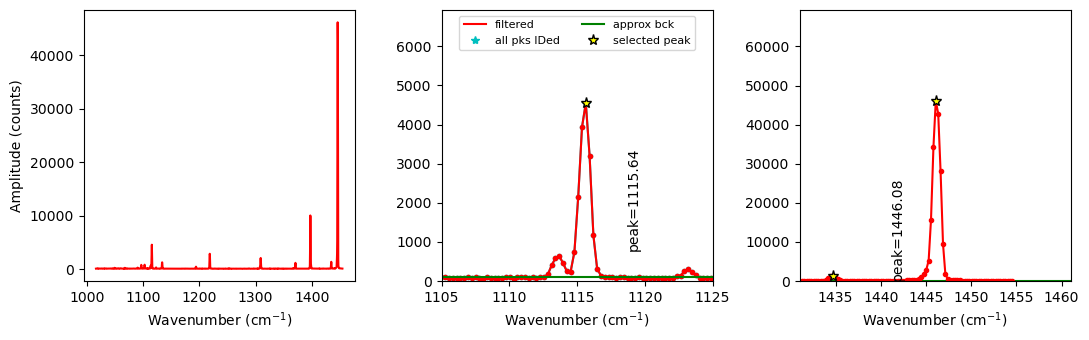

In [10]:
exclude_range_1=None
exclude_range_2=None


Neon_id_config=pf.Neon_id_config(height=10,  
            distance=1, prominence=1000, 
            width=1, threshold=0.6,
            peak1_cent=line_1, peak2_cent=line_2, n_peaks=6, 
            exclude_range_1=exclude_range_1, 
            exclude_range_2=exclude_range_2)
Neon_id_config

Ne, df_fit_params=pf.identify_Ne_lines(path=spectra_path,
filename=filename, filetype=filetype,
config=Neon_id_config, print_df=False)
df_fit_params

### Tweak peak parameters
- One important thing is the background positions, these are defined relative to the peak position. Once you tweak them for each instrument, you chould be good to go. 
- Another thing is how many peaks you want for Peak1, 'peaks_1', for the 1117 line, you'll need 2 if you have the clear secondary peak seen above. 

In [11]:
pf.Ne_peak_config()

Ne_peak_config(model_name='PseudoVoigtModel', N_poly_pk1_baseline=1, N_poly_pk2_baseline=1, lower_bck_pk1=(-50, -25), upper_bck1_pk1=(8, 15), upper_bck2_pk1=(30, 50), lower_bck_pk2=(-44.2, -22), upper_bck1_pk2=(15, 50), upper_bck2_pk2=(50, 51), peaks_1=2, DeltaNe_ideal=330.477634, x_range_baseline_pk1=20, y_range_baseline_pk1=200, x_range_baseline_pk2=20, y_range_baseline_pk2=200, pk1_sigma=0.4, pk2_sigma=0.4, x_range_peak=15, x_range_residual=7, LH_offset_mini=(1.5, 3), x_span_pk1=None, x_span_pk2=None)

In [12]:
model_name='PseudoVoigtModel'
Ne_Config_est=pf.Ne_peak_config(model_name=model_name,
 DeltaNe_ideal=ideal_split['Ne_Split'], peaks_1=2, LH_offset_mini=[2, 5],
pk1_sigma=0.6, pk2_sigma=0.5,
lower_bck_pk1=(-40, -30), upper_bck1_pk1=[40, 70], upper_bck2_pk1=[40, 70],
lower_bck_pk2=[-40, -20], upper_bck1_pk2=[5, 10], upper_bck2_pk2=[25, 40],
x_range_peak=5, x_span_pk1=[-10, 8], x_span_pk2=[-10, 10],
N_poly_pk2_baseline=2 )

,filename,pk2_peak_cent,pk2_amplitude,pk2_sigma,pk2_gamma,error_pk2,Peak2_Prop_Lor,pk1_peak_cent,pk1_amplitude,pk1_sigma,pk1_gamma,error_pk1,Peak1_Prop_Lor,deltaNe,Ne_Corr,Ne_Corr_min,Ne_Corr_max,residual_pk2,residual_pk1,residual_pk1+pk2
0,Ne7_01.txt,1446.162932,50320.420519,0.483723,None,1,0.074469,1115.57164,4376.817873,0.451127,None,NaN,0.0095,330.591292,0.999656,NaN,NaN,161.532357,25.813903,187.346261


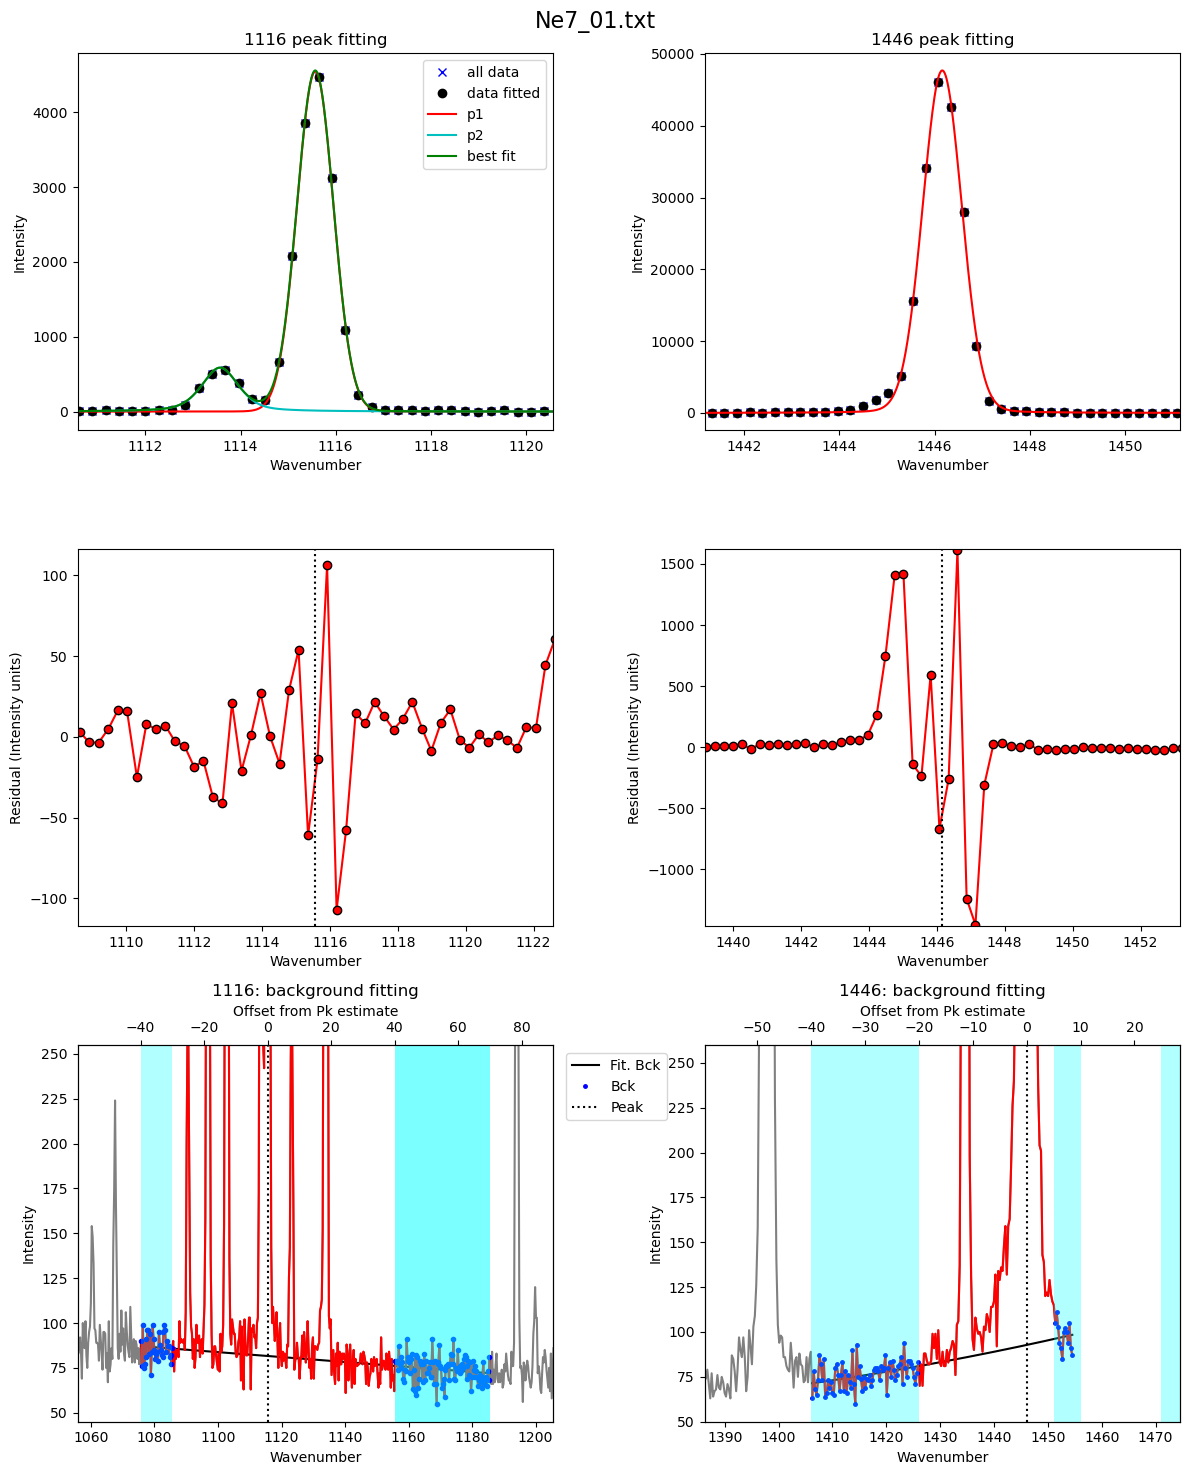

In [13]:

df_test_params=pf.fit_Ne_lines(Ne=Ne, filename=filename,
path=spectra_path, prefix=False,
config=Ne_Config_est,
    Ne_center_1=df_fit_params['Peak1_cent'].iloc[i], 
    Ne_center_2=df_fit_params['Peak2_cent'].iloc[i],
    Ne_prom_1=df_fit_params['Peak1_prom'].iloc[i],
    Ne_prom_2=df_fit_params['Peak2_prom'].iloc[i],
    const_params=False)                                                                 
                                                                     
display(df_test_params)

In [14]:
## Update sigma based on this one fit
Ne_Config_tweak=Ne_Config_est
Ne_Config_tweak.pk1_sigma=df_test_params['pk1_sigma'].iloc[0]
Ne_Config_tweak.pk2_sigma=df_test_params['pk2_sigma'].iloc[0]

## Now fit all Ne files here using these parameters. 
- If you select plot_figure=False, the loop will be quick. 
- But if its True, you can to inspect the figures.

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:15<00:00,  1.27s/it]


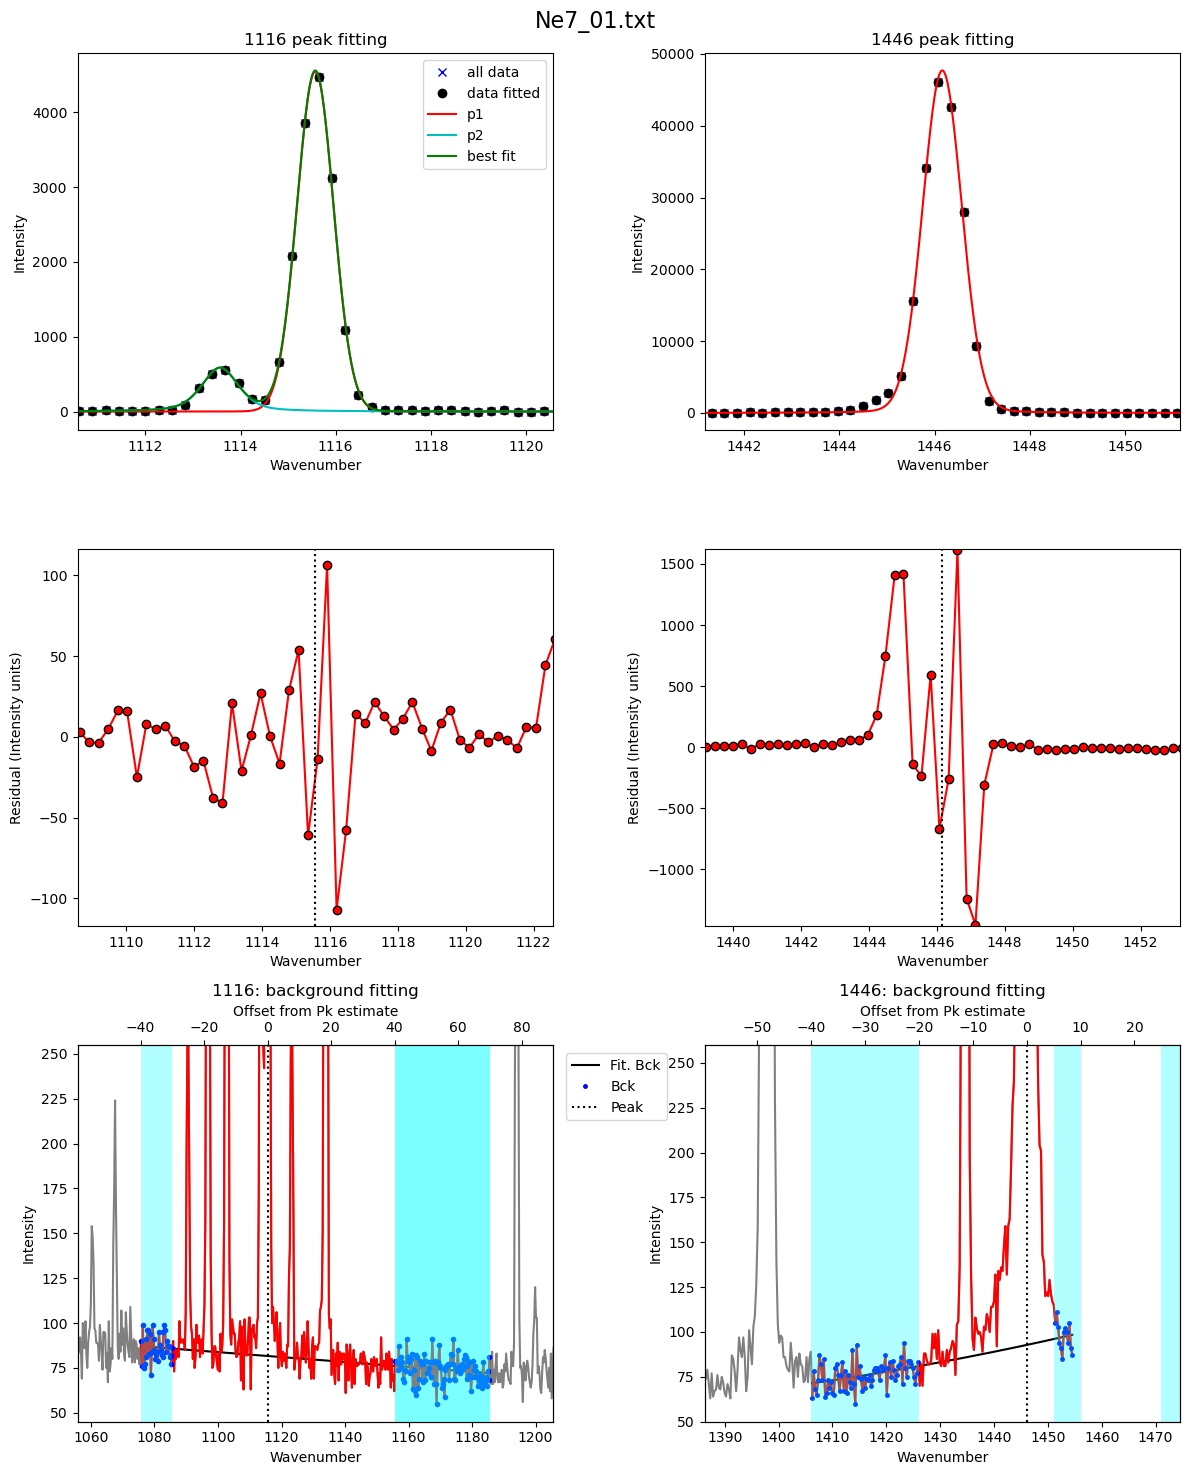

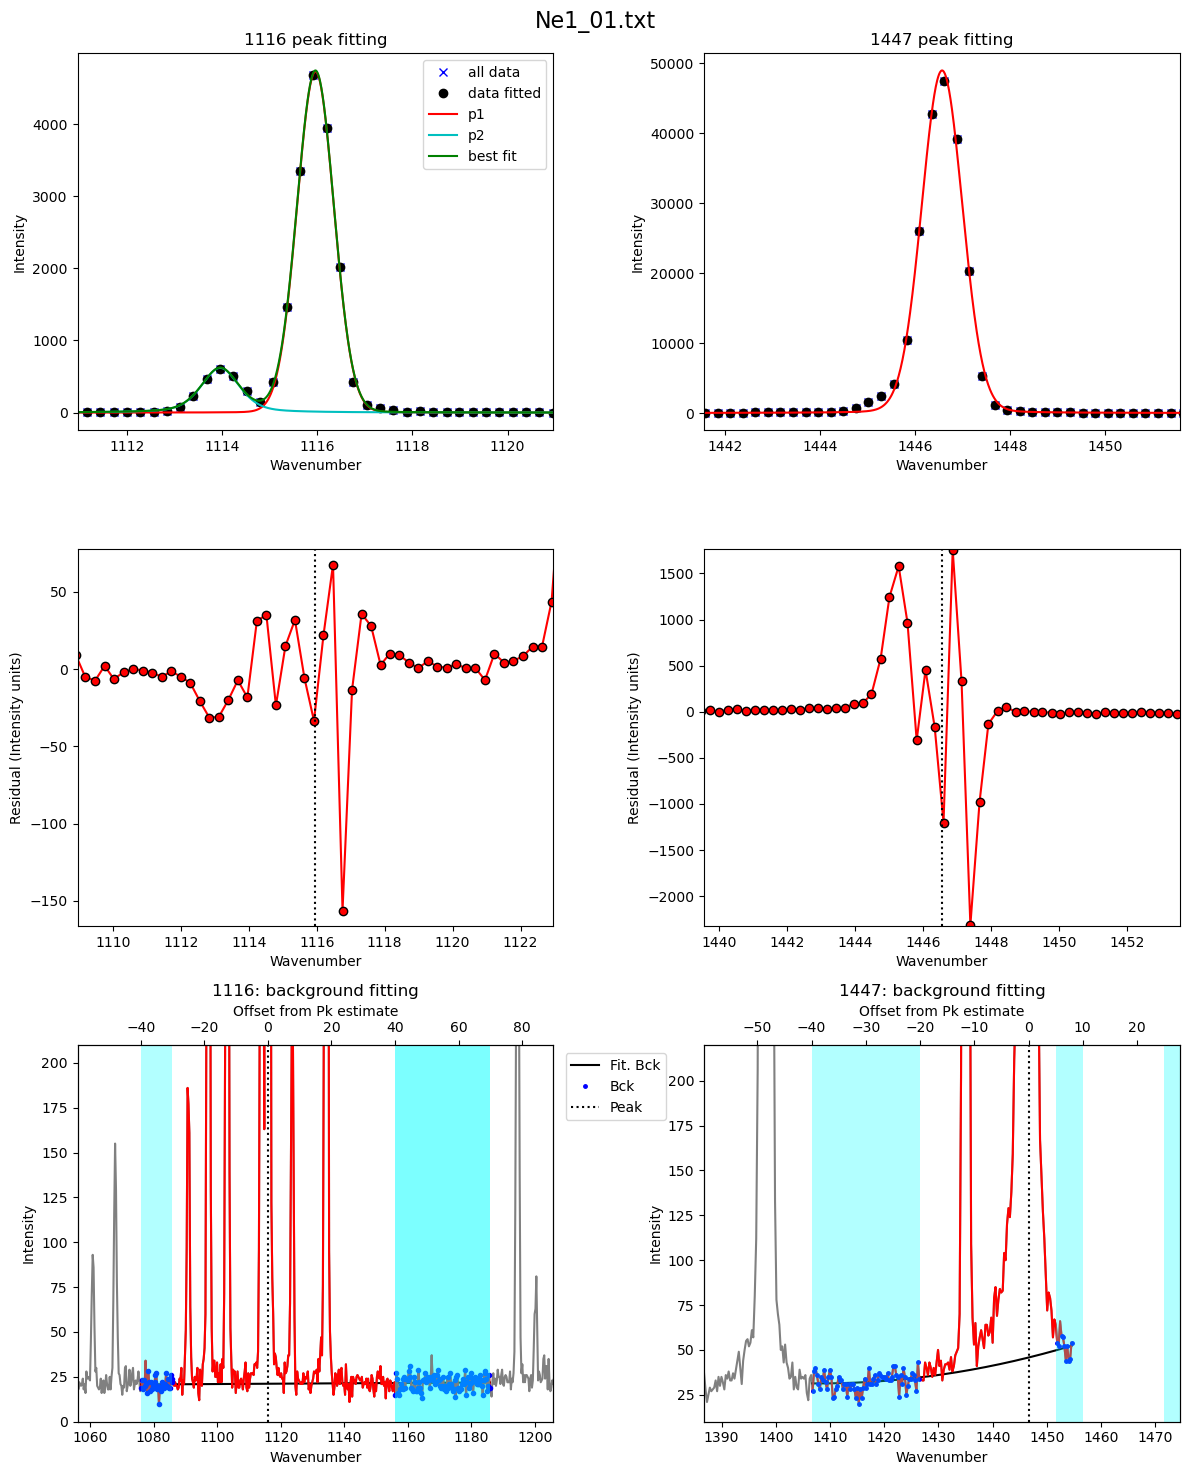

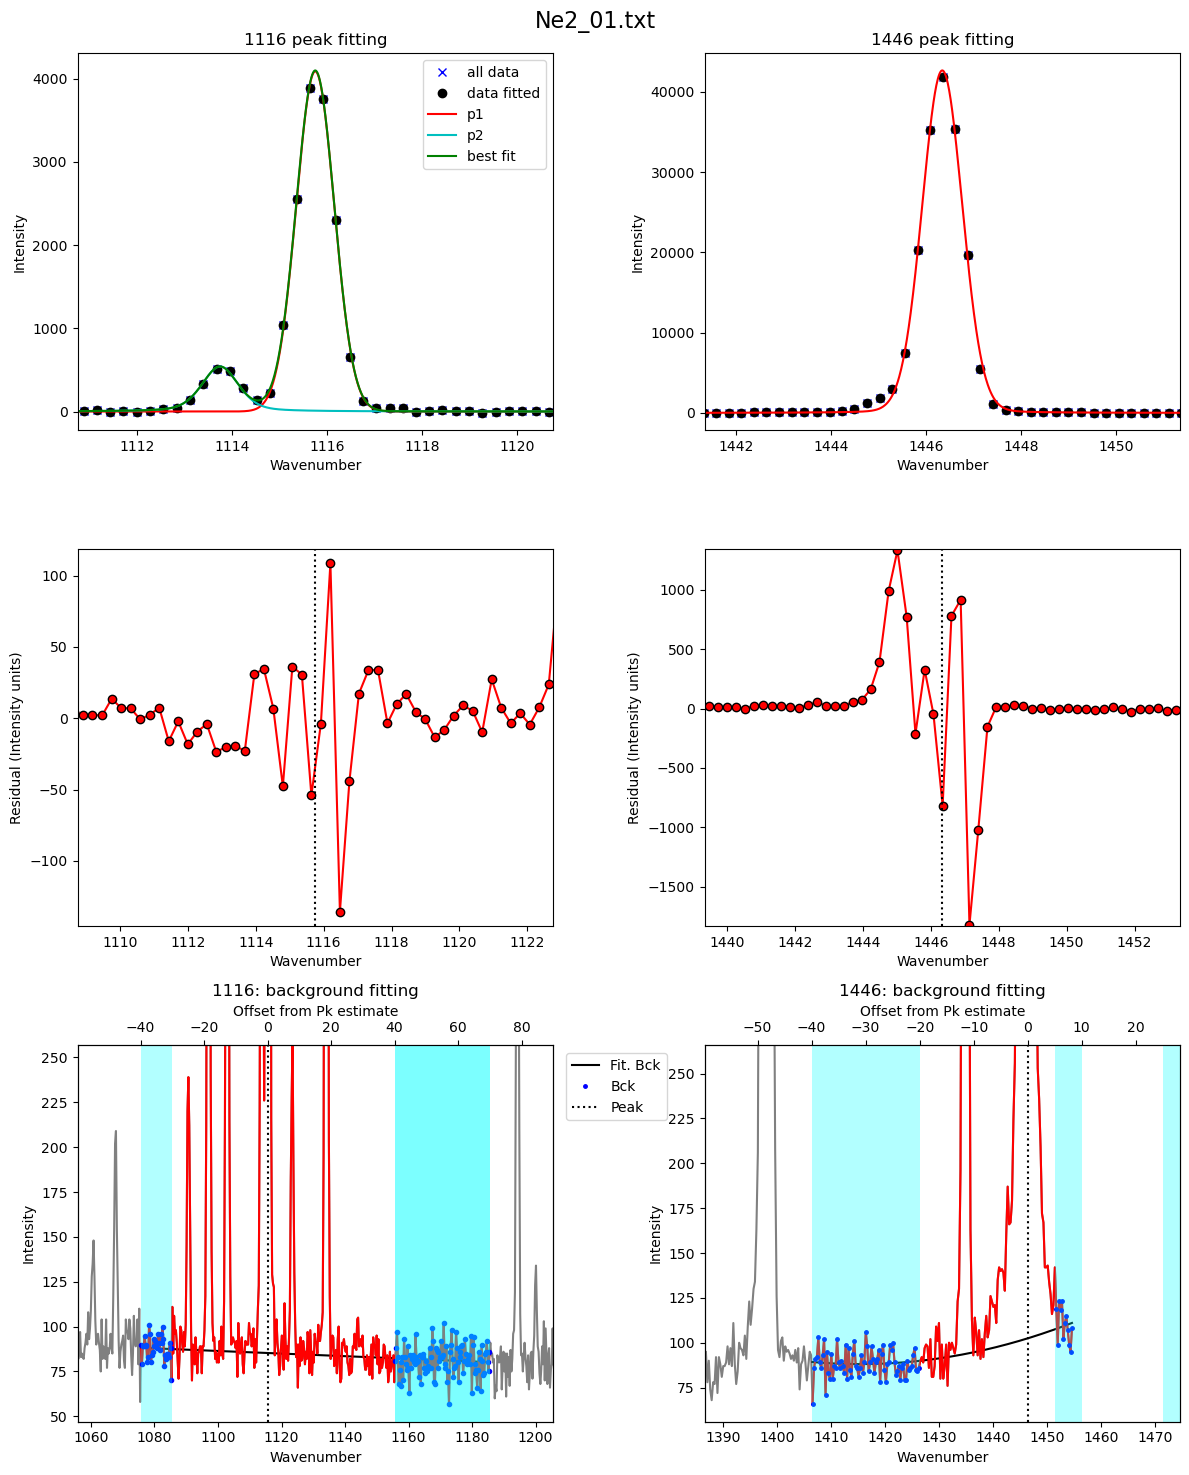

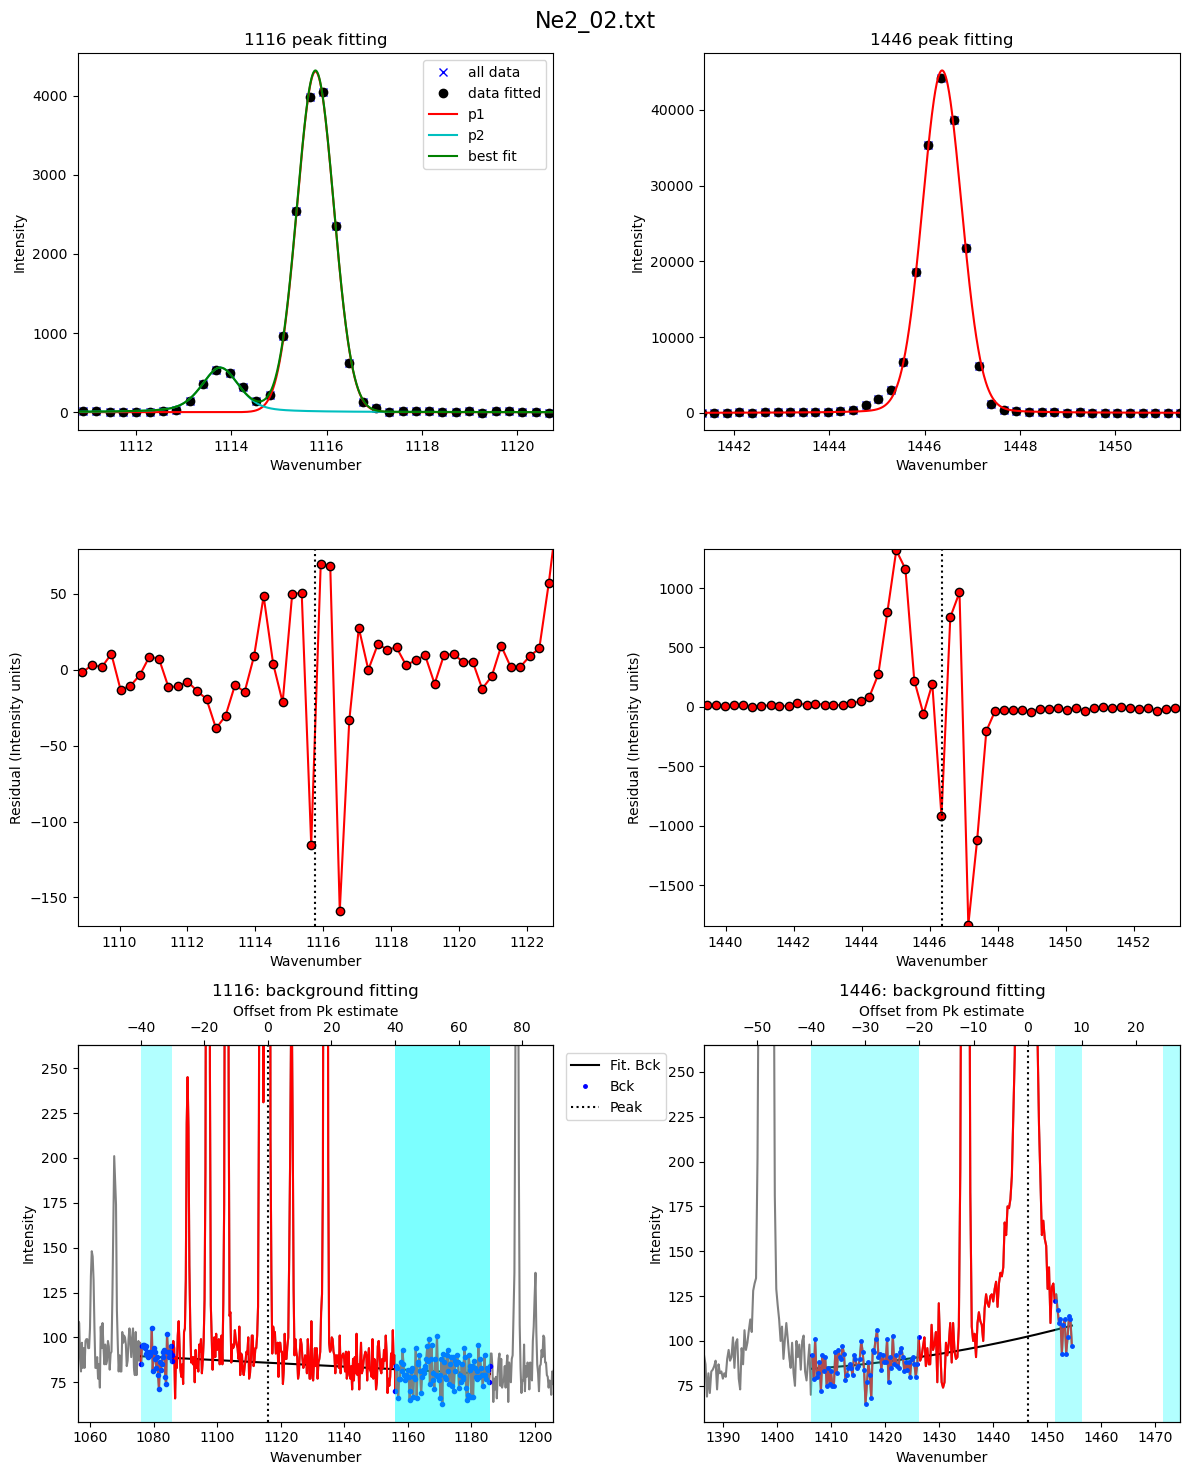

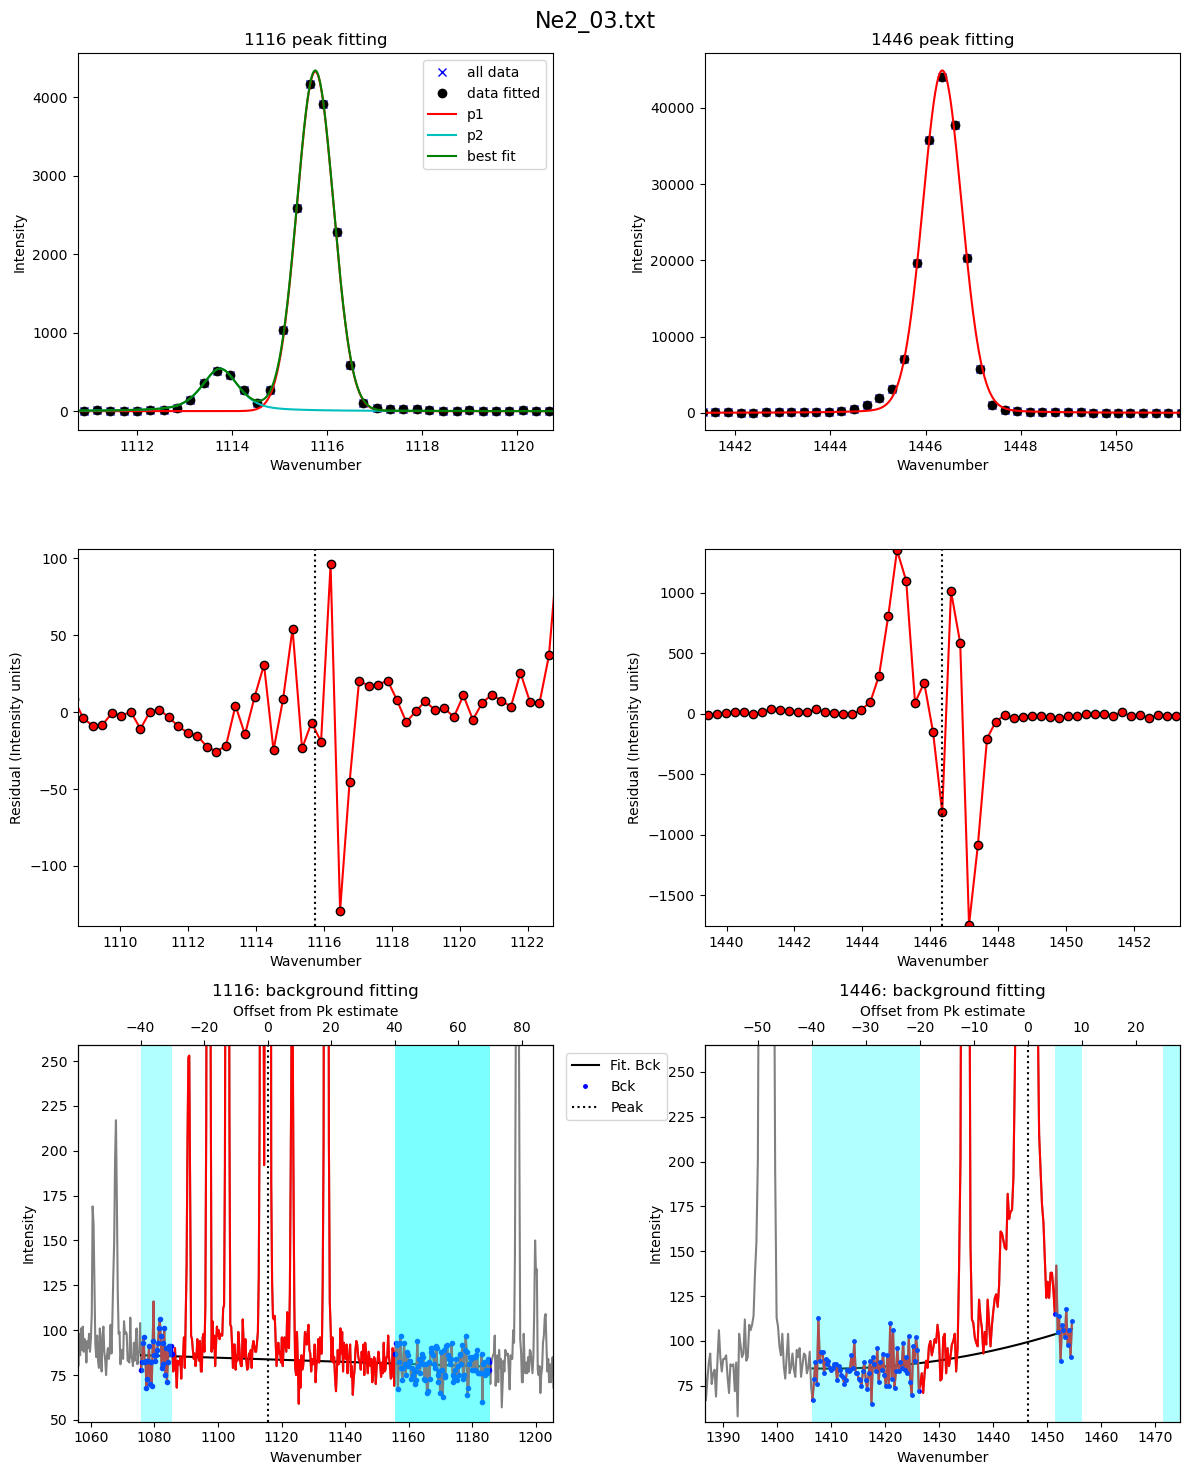

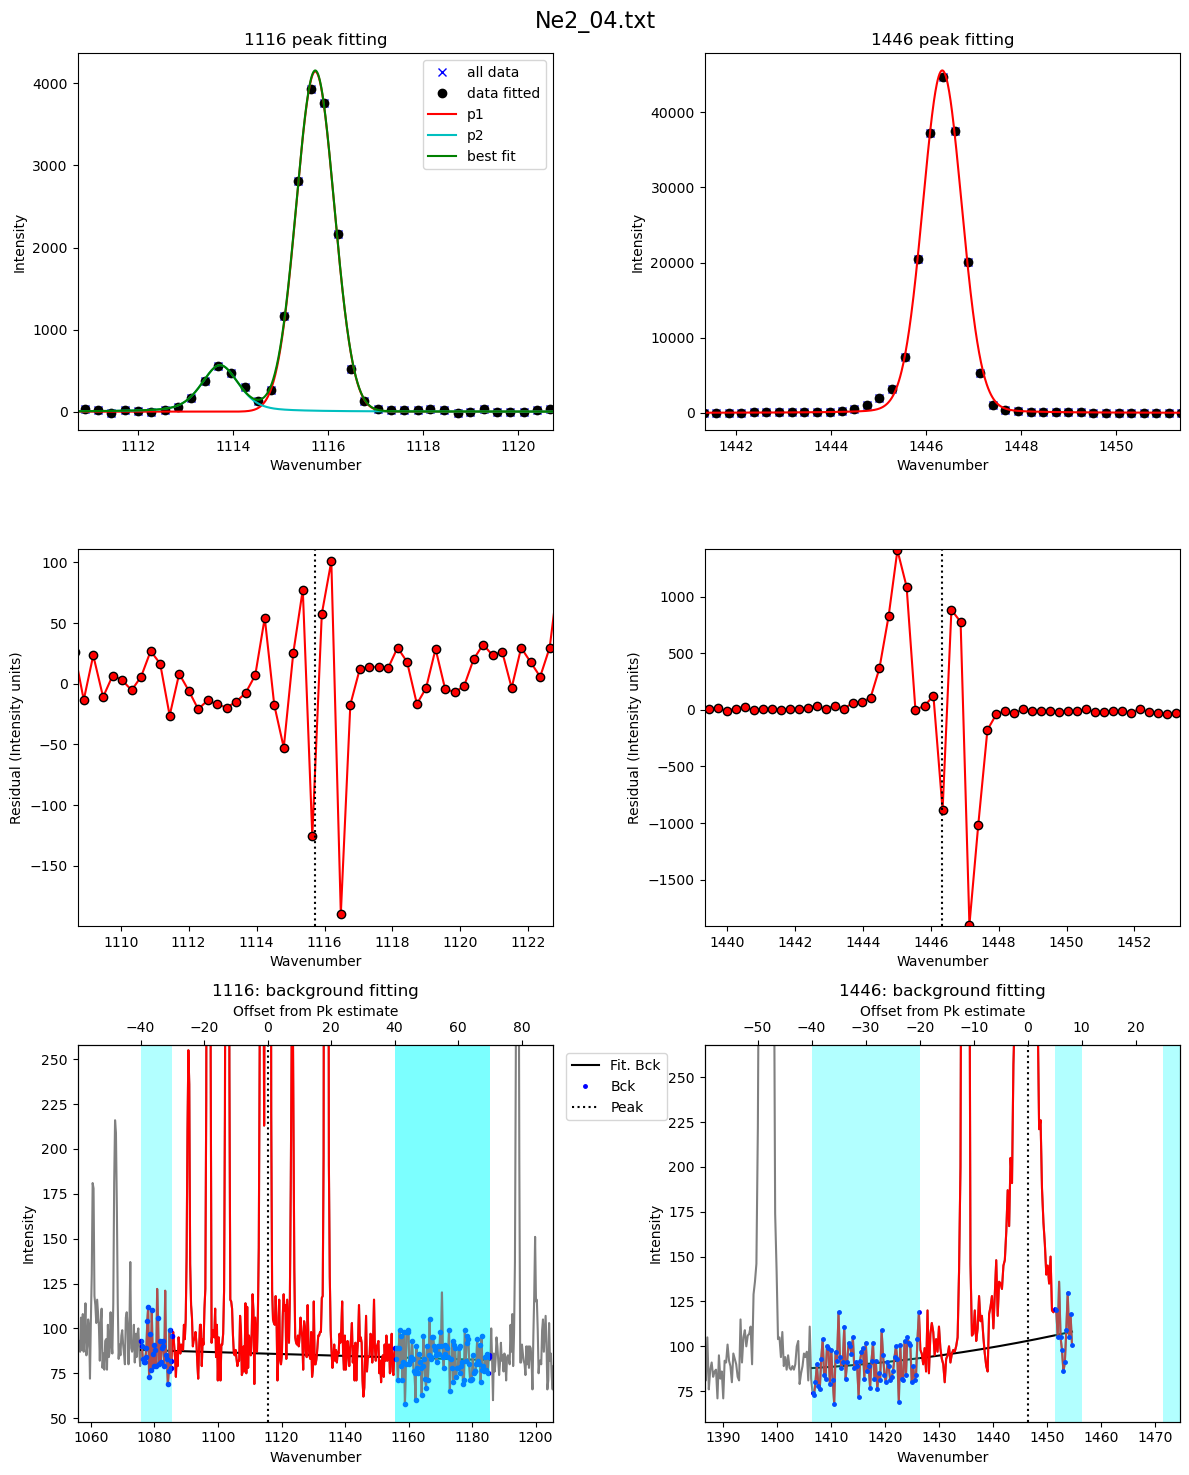

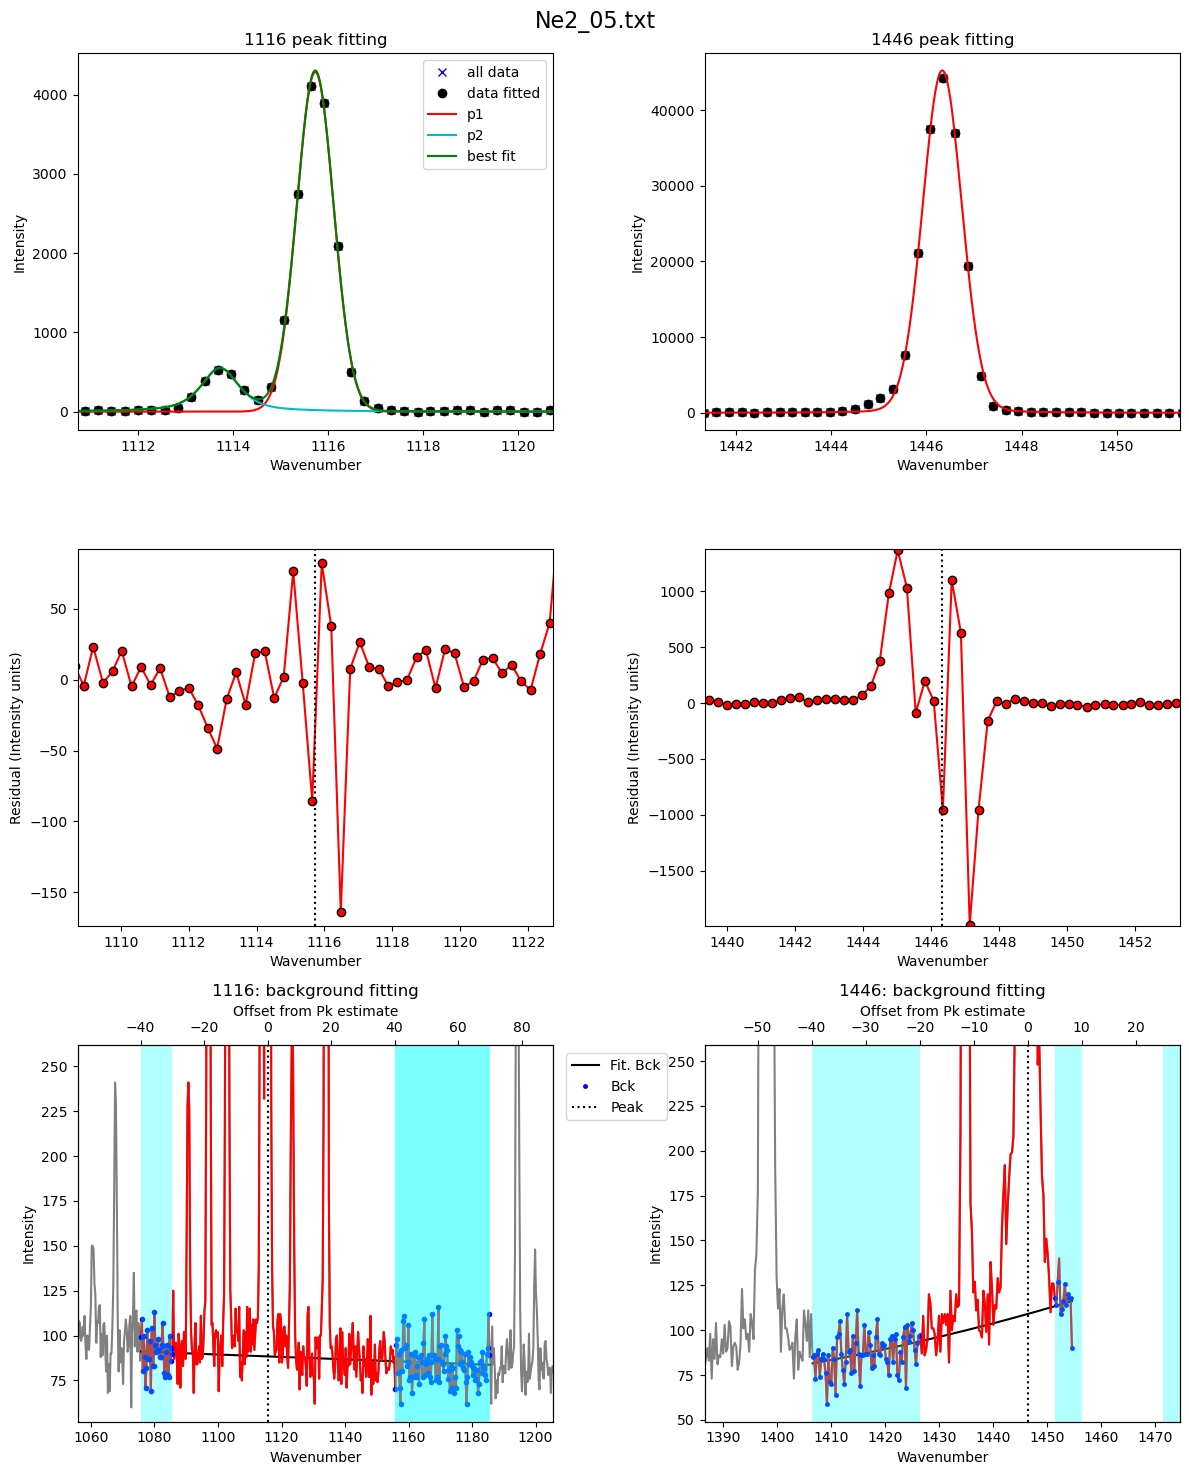

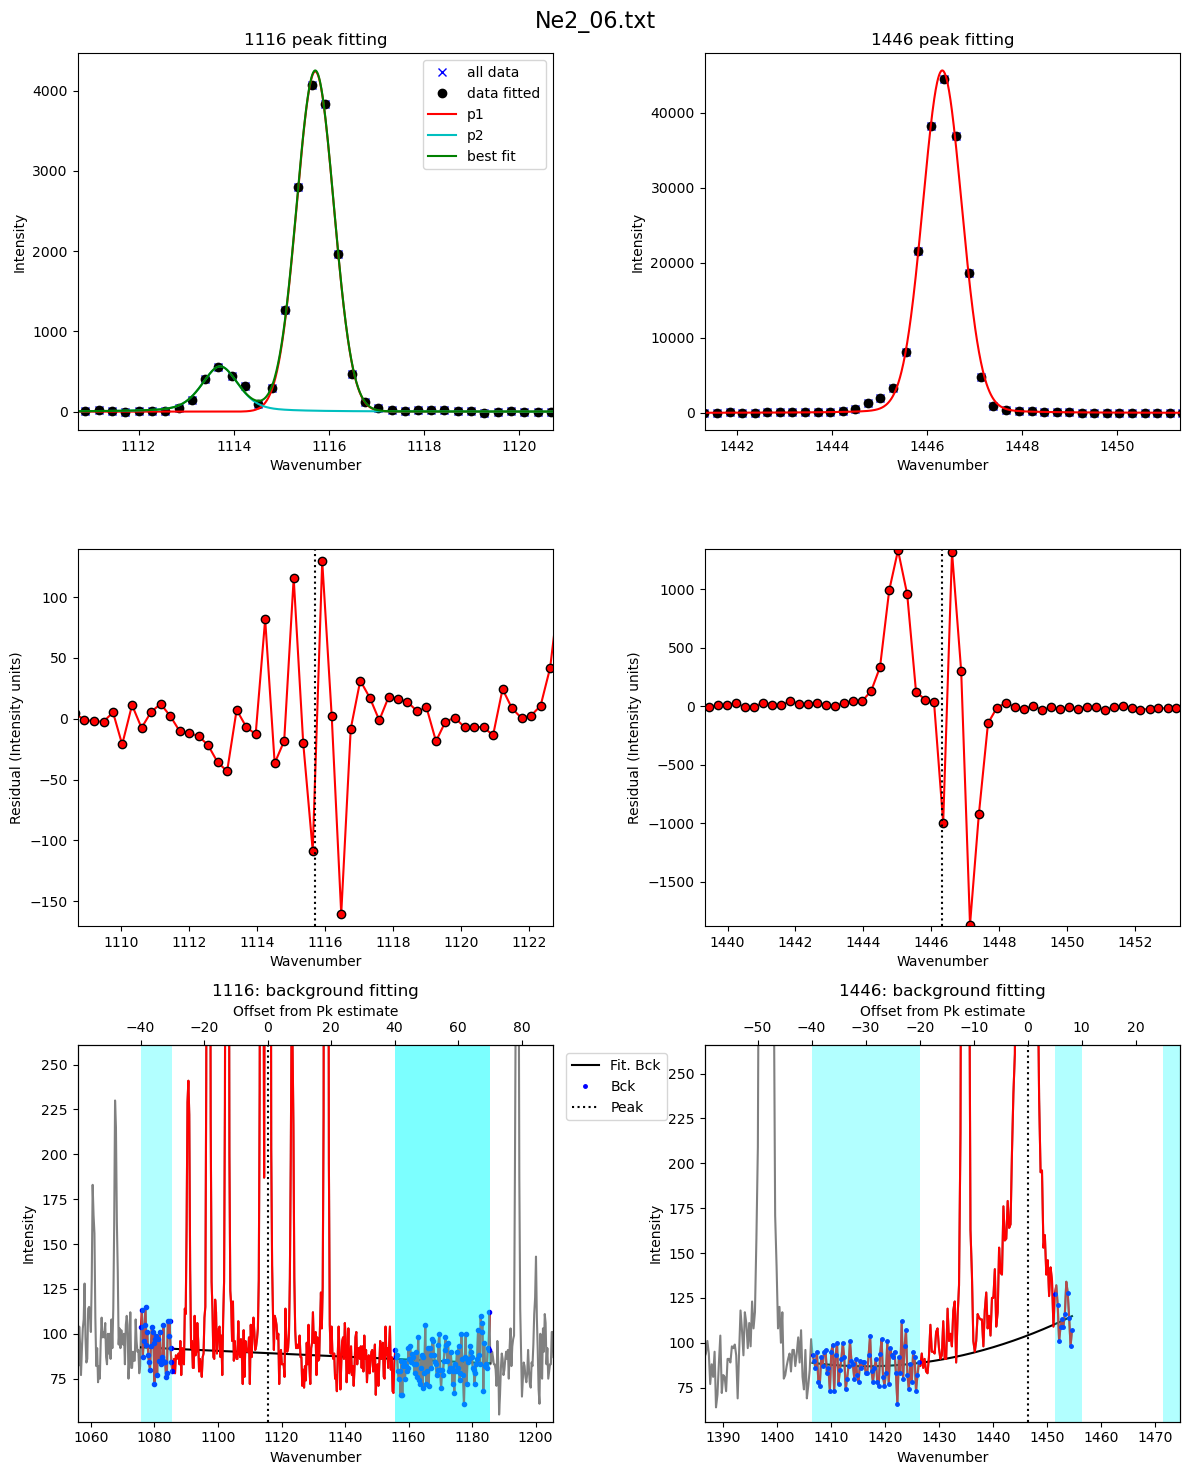

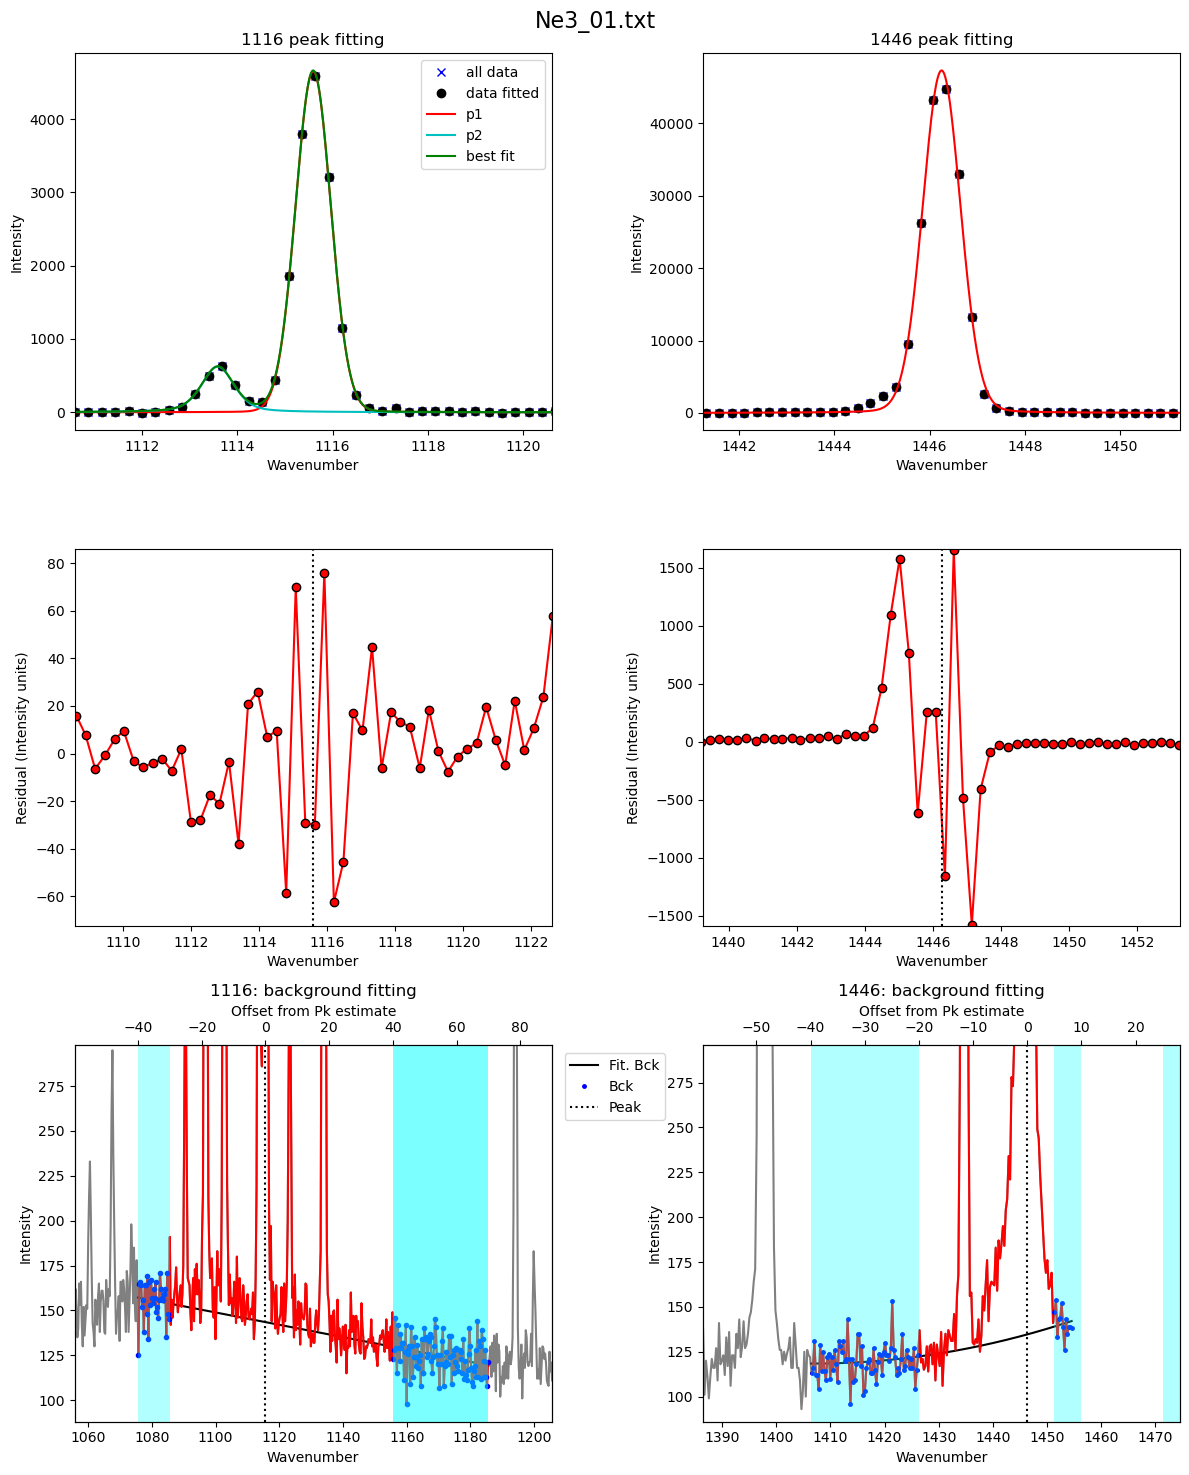

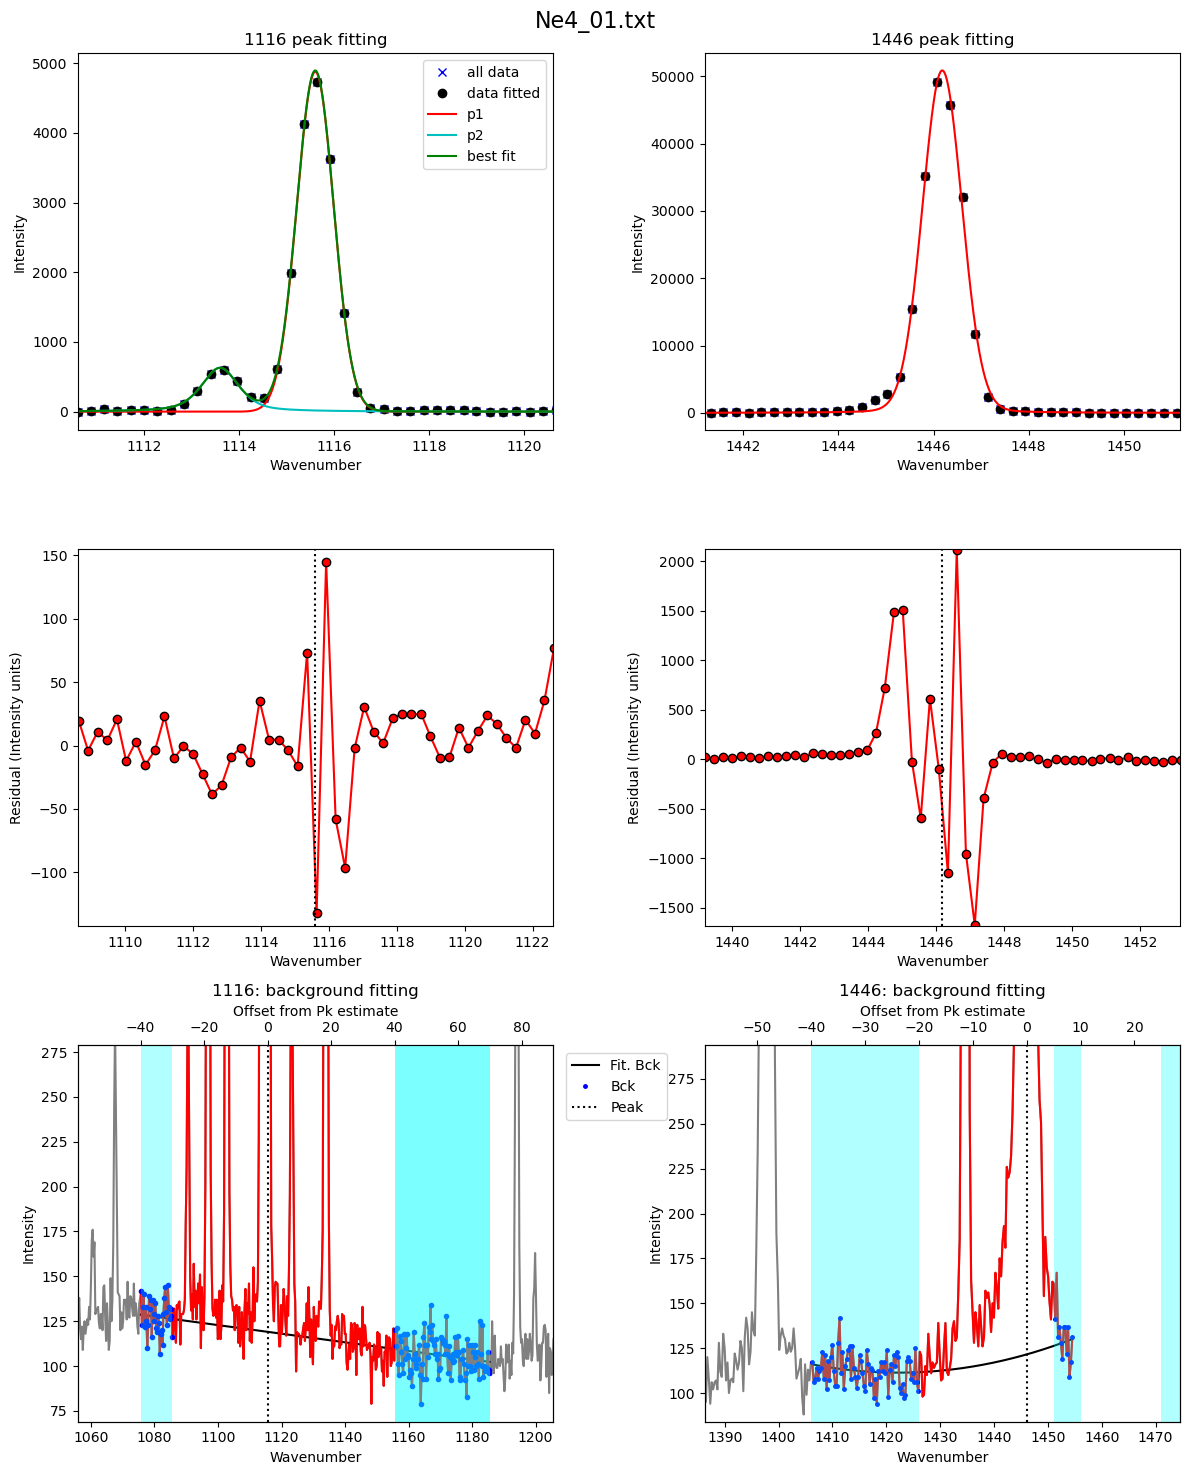

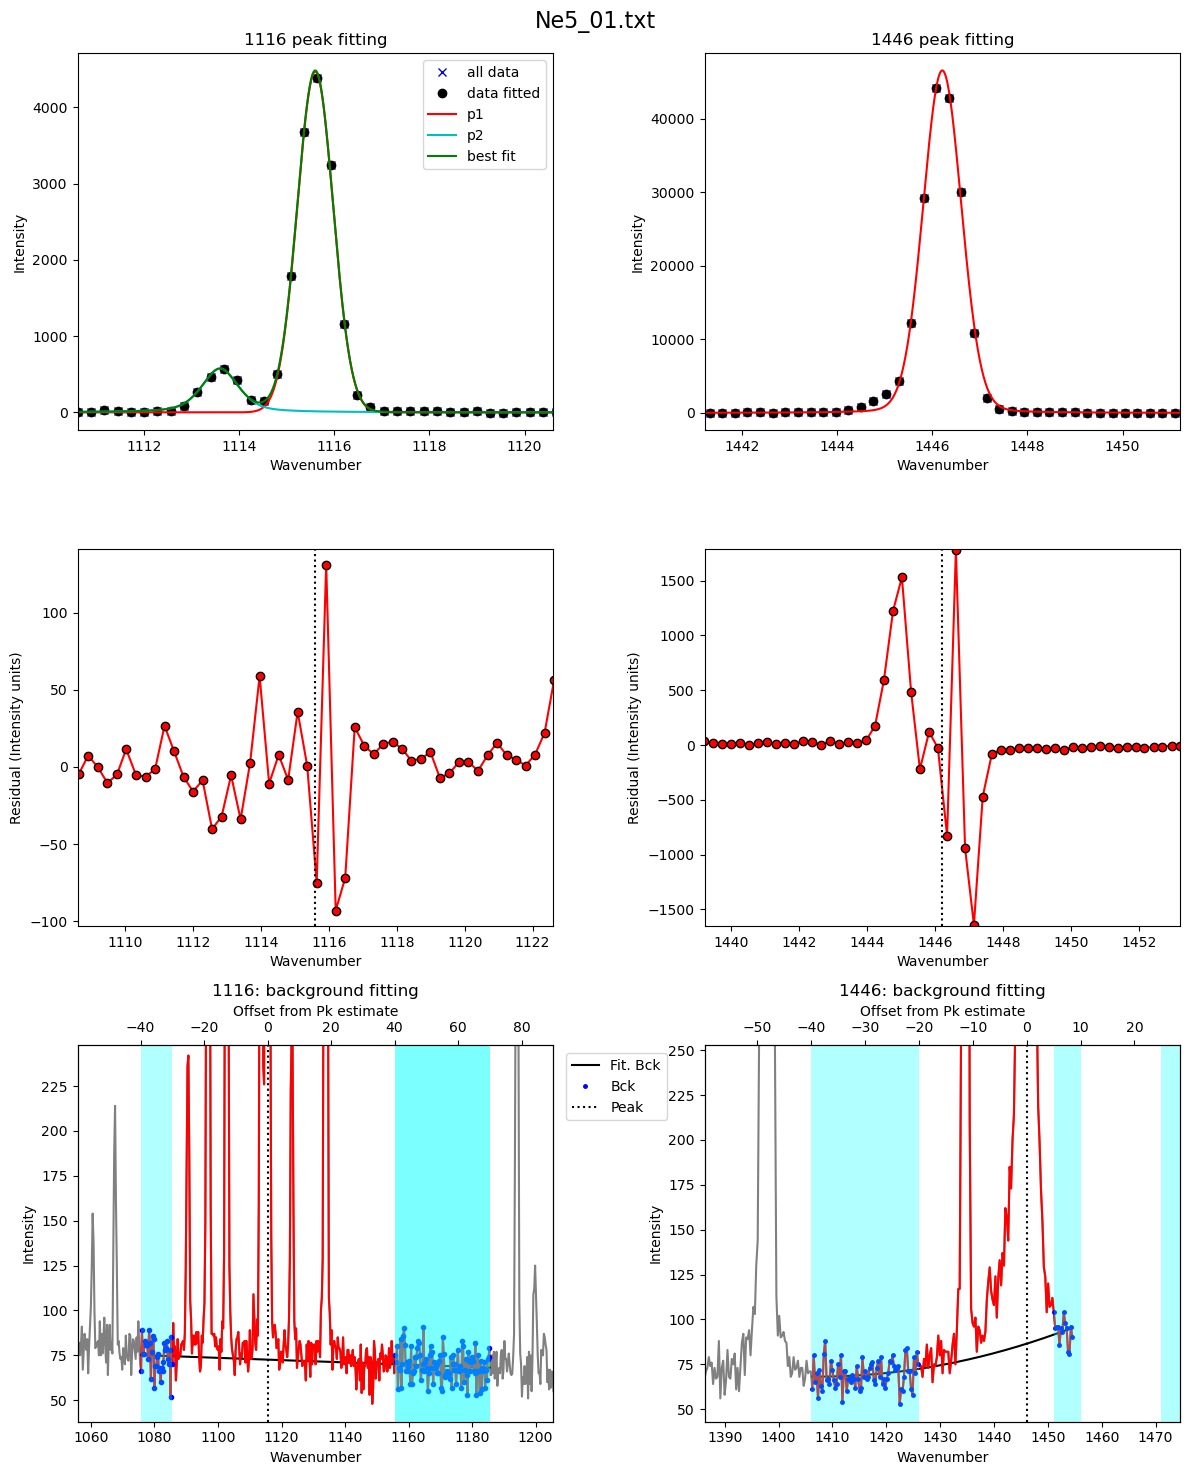

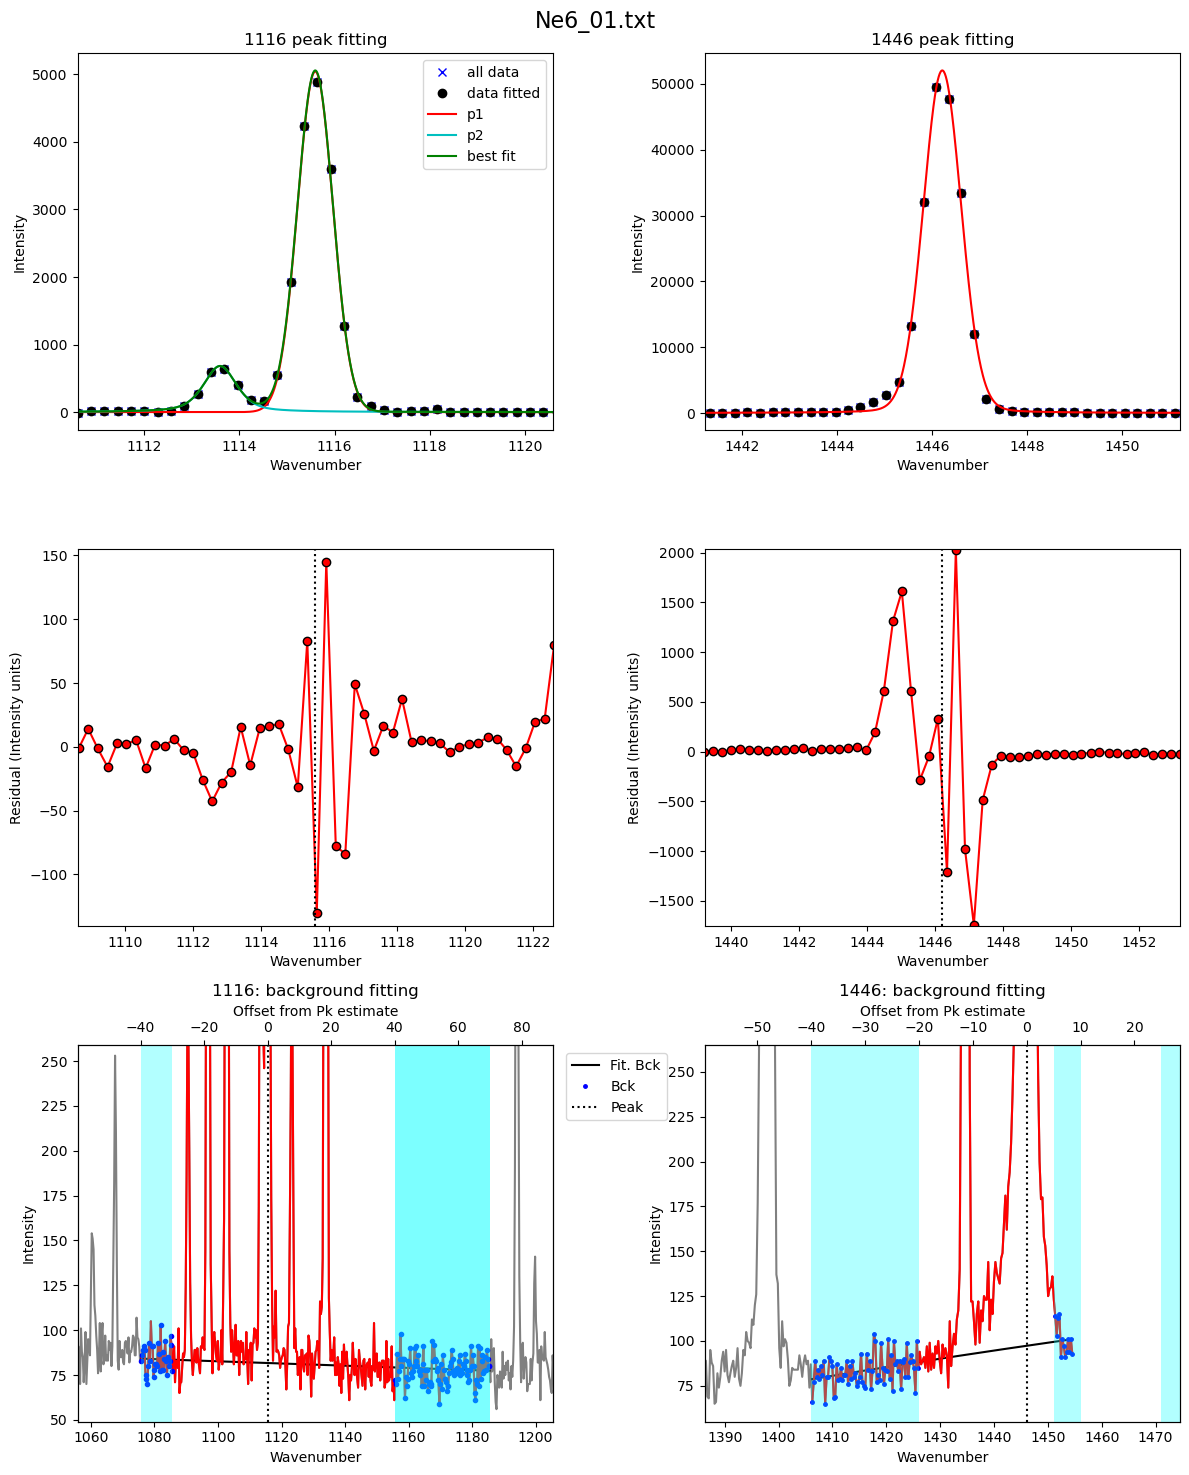

In [15]:
df2 =pf.loop_Ne_lines(files=Ne_files, spectra_path=spectra_path, 
filetype=filetype, config_ID_peaks=Neon_id_config, 
config=Ne_Config_tweak,
df_fit_params=df_fit_params,                    
plot_figure=True)

In [16]:
df2

,filename,Ne_Corr,deltaNe,pk2_peak_cent,pk1_peak_cent,pk2_amplitude,pk1_amplitude,residual_pk2,residual_pk1,pk2_sigma,pk2_gamma,error_pk2,Peak2_Prop_Lor,pk1_sigma,pk1_gamma,error_pk1,Peak1_Prop_Lor,Ne_Corr_min,Ne_Corr_max,residual_pk1+pk2
0,Ne7_01.txt,0.999656,330.591292,1446.162932,1115.571640,50320.335794,4376.817369,161.534837,25.814585,0.483725,None,1,0.074458,0.451124,None,NaN,9.511879e-03,NaN,NaN,187.349422
1,Ne1_01.txt,0.999617,330.604179,1446.567399,1115.963220,53615.151848,4618.136062,193.721469,21.778559,0.502930,None,1,0.068242,0.454969,None,NaN,2.506772e-02,NaN,NaN,215.500028
2,Ne2_01.txt,0.999674,330.585319,1446.339237,1115.753918,46083.241979,4088.535881,153.027302,22.699188,0.496533,None,1,0.066733,0.469905,None,NaN,8.700949e-09,NaN,NaN,175.726489
3,Ne2_02.txt,0.999621,330.602895,1446.367714,1115.764819,47909.785993,4157.197720,155.918697,27.684262,0.483092,None,1,0.091152,0.453523,None,NaN,8.417988e-07,NaN,NaN,183.602959
4,Ne2_03.txt,0.999619,330.603457,1446.352120,1115.748663,47642.728881,4177.351081,151.446694,22.203639,0.483117,None,1,0.095615,0.452573,None,NaN,4.149598e-03,NaN,NaN,173.650333
5,Ne2_04.txt,0.999589,330.613500,1446.340555,1115.727056,48291.589033,4146.209526,152.522608,30.114420,0.483327,None,1,0.092150,0.469699,None,NaN,3.509293e-11,NaN,NaN,182.637028
6,Ne2_05.txt,0.999621,330.602830,1446.331857,1115.729027,47891.114696,4155.833934,158.210545,25.238680,0.485405,None,1,0.074026,0.454688,None,NaN,4.435925e-03,NaN,NaN,183.449224
7,Ne2_06.txt,0.999605,330.608311,1446.323324,1115.715013,48336.370381,4143.677202,150.422875,27.119122,0.483591,None,1,0.087263,0.459209,None,NaN,5.365447e-09,NaN,NaN,177.541997
8,Ne3_01.txt,0.999448,330.660318,1446.252612,1115.592294,48324.766856,4342.947095,167.960888,25.013519,0.466202,None,1,0.088437,0.433919,None,NaN,3.275276e-02,NaN,NaN,192.974407
9,Ne4_01.txt,0.999679,330.583803,1446.183599,1115.599796,54338.405560,4728.422029,183.939985,29.577057,0.489386,None,1,0.077109,0.455341,None,NaN,2.333062e-08,NaN,NaN,213.517042


## Now extract metadata to get a timestamp for each file

In [17]:
meta=pf.stitch_metadata_in_loop_horiba(AllFiles=Ne_files,
path=spectra_path)
meta

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 38.70it/s]


,filename,spectral_name,date,Month,Day,power (mw),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral_Center
0,Ne7_01.txt,Ne7,06.05.2022,May,2022-05-06,no data,45.0,2.0,x100 LWD,90.0,12:39:14,45554,1240.02
1,Ne1_01.txt,Ne1,06.05.2022,May,2022-05-06,no data,35.0,2.0,x100 LWD,70.0,08:07:26,29246,1240.02
2,Ne2_01.txt,Ne2,06.05.2022,May,2022-05-06,no data,55.0,2.0,x100 LWD,110.0,08:31:46,30706,1240.02
3,Ne2_02.txt,Ne2,06.05.2022,May,2022-05-06,no data,65.0,2.0,x100 LWD,130.0,08:35:05,30905,1240.02
4,Ne2_03.txt,Ne2,06.05.2022,May,2022-05-06,no data,65.0,2.0,x100 LWD,130.0,08:37:21,31041,1240.02
5,Ne2_04.txt,Ne2,06.05.2022,May,2022-05-06,no data,65.0,1.0,x100 LWD,65.0,08:39:44,31184,1240.02
6,Ne2_05.txt,Ne2,06.05.2022,May,2022-05-06,no data,65.0,1.0,x100 LWD,65.0,08:41:56,31316,1240.02
7,Ne2_06.txt,Ne2,06.05.2022,May,2022-05-06,no data,65.0,1.0,x100 LWD,65.0,08:44:15,31455,1240.02
8,Ne3_01.txt,Ne3,06.05.2022,May,2022-05-06,no data,55.0,2.0,x100 LWD,110.0,09:38:44,34724,1240.02
9,Ne4_01.txt,Ne4,06.05.2022,May,2022-05-06,no data,45.0,2.0,x100 LWD,90.0,10:19:15,37155,1240.02


In [18]:
# Strip away suffix and prefix if needed
print(meta['filename'][0])

Ne7_01.txt


In [19]:
# remove these to get the pure file name you can compare 
file_m=pf.extracting_filenames_generic(names=meta['filename'],
    prefix=False, str_prefix=None,
   file_type='.txt')
file_m

array(['Ne7_01', 'Ne1_01', 'Ne2_01', 'Ne2_02', 'Ne2_03', 'Ne2_04',
       'Ne2_05', 'Ne2_06', 'Ne3_01', 'Ne4_01', 'Ne5_01', 'Ne6_01'],
      dtype=object)

In [20]:
# Do the same for spectra, e.g., work out what you need to strip off
print(df2['filename'][0])

Ne7_01.txt


In [21]:
file_s=pf.extracting_filenames_generic(names=df2['filename'],
    prefix=False, str_prefix=' ',
   file_type='.txt')
file_s

array(['Ne7_01', 'Ne1_01', 'Ne2_01', 'Ne2_02', 'Ne2_03', 'Ne2_04',
       'Ne2_05', 'Ne2_06', 'Ne3_01', 'Ne4_01', 'Ne5_01', 'Ne6_01'],
      dtype=object)

## Combine 2 dataframes
- Here we add a new column to each dataframe with these stripped back names, and then merge the 2 dataframes

In [22]:
meta['name_for_matching']=file_m
df2['name_for_matching']=file_s
df_combo=df2.merge(meta, on='name_for_matching')

## Now lets inspect changes in Ne correction factor with time
- Normally, you can spot outliers this way

In [23]:
df_combo_sort=df_combo.sort_values(by='sec since midnight')
df_combo_sort.to_excel('PseudoVoigt.xlsx')

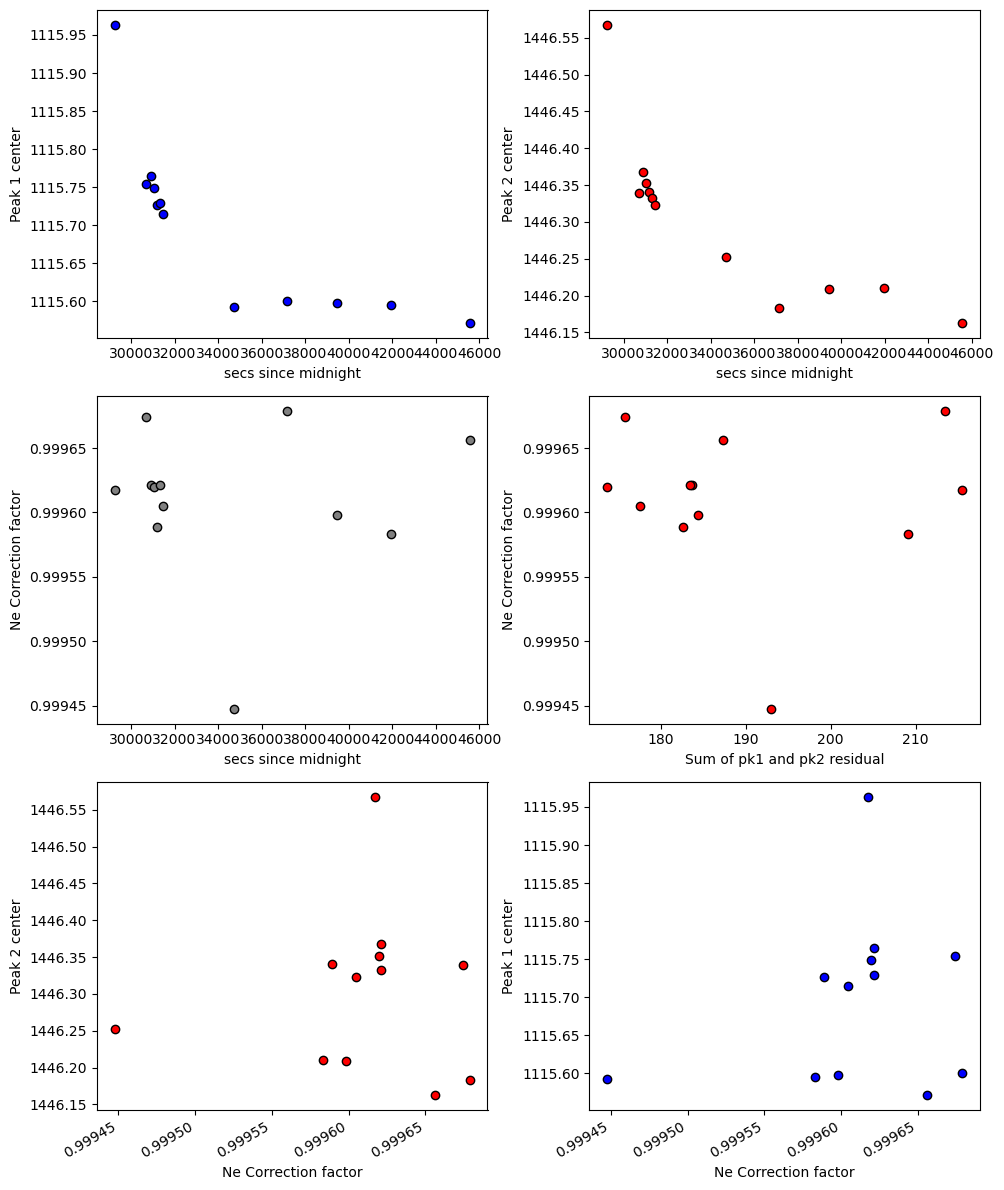

In [24]:
fig=pf.plot_Ne_corrections(df=df_combo, x_axis=df_combo['sec since midnight'],
                      x_label='secs since midnight')


In [25]:
df_combo_sort=df_combo.sort_values(by='sec since midnight')
df_combo

,filename_x,Ne_Corr,deltaNe,pk2_peak_cent,pk1_peak_cent,pk2_amplitude,pk1_amplitude,residual_pk2,residual_pk1,pk2_sigma,...,Month,Day,power (mw),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral_Center
0,Ne7_01.txt,0.999656,330.591292,1446.162932,1115.571640,50320.335794,4376.817369,161.534837,25.814585,0.483725,...,May,2022-05-06,no data,45.0,2.0,x100 LWD,90.0,12:39:14,45554,1240.02
1,Ne1_01.txt,0.999617,330.604179,1446.567399,1115.963220,53615.151848,4618.136062,193.721469,21.778559,0.502930,...,May,2022-05-06,no data,35.0,2.0,x100 LWD,70.0,08:07:26,29246,1240.02
2,Ne2_01.txt,0.999674,330.585319,1446.339237,1115.753918,46083.241979,4088.535881,153.027302,22.699188,0.496533,...,May,2022-05-06,no data,55.0,2.0,x100 LWD,110.0,08:31:46,30706,1240.02
3,Ne2_02.txt,0.999621,330.602895,1446.367714,1115.764819,47909.785993,4157.197720,155.918697,27.684262,0.483092,...,May,2022-05-06,no data,65.0,2.0,x100 LWD,130.0,08:35:05,30905,1240.02
4,Ne2_03.txt,0.999619,330.603457,1446.352120,1115.748663,47642.728881,4177.351081,151.446694,22.203639,0.483117,...,May,2022-05-06,no data,65.0,2.0,x100 LWD,130.0,08:37:21,31041,1240.02
5,Ne2_04.txt,0.999589,330.613500,1446.340555,1115.727056,48291.589033,4146.209526,152.522608,30.114420,0.483327,...,May,2022-05-06,no data,65.0,1.0,x100 LWD,65.0,08:39:44,31184,1240.02
6,Ne2_05.txt,0.999621,330.602830,1446.331857,1115.729027,47891.114696,4155.833934,158.210545,25.238680,0.485405,...,May,2022-05-06,no data,65.0,1.0,x100 LWD,65.0,08:41:56,31316,1240.02
7,Ne2_06.txt,0.999605,330.608311,1446.323324,1115.715013,48336.370381,4143.677202,150.422875,27.119122,0.483591,...,May,2022-05-06,no data,65.0,1.0,x100 LWD,65.0,08:44:15,31455,1240.02
8,Ne3_01.txt,0.999448,330.660318,1446.252612,1115.592294,48324.766856,4342.947095,167.960888,25.013519,0.466202,...,May,2022-05-06,no data,55.0,2.0,x100 LWD,110.0,09:38:44,34724,1240.02
9,Ne4_01.txt,0.999679,330.583803,1446.183599,1115.599796,54338.405560,4728.422029,183.939985,29.577057,0.489386,...,May,2022-05-06,no data,45.0,2.0,x100 LWD,90.0,10:19:15,37155,1240.02


In [29]:
df_combo_sort.to_clipboard(excel=True)

## Exclude ones that don't look right...
- The filter_Ne_Line_neighbours excludes Ne lines that have a correction factor more than "offset" from their N neighbours (defined by "number_av")
- Tweak offset and number_av until you exclude the ones that dont look right

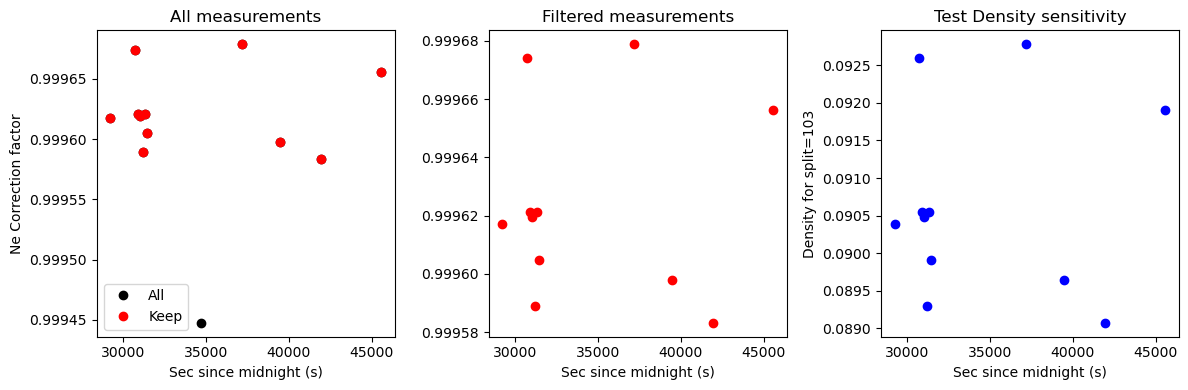

In [35]:
filt=pf.filter_Ne_Line_neighbours(Corr_factor=df_combo['Ne_Corr'], 
                    number_av=3, offset=0.0001)
# Now lets plot this to see
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
ax1.plot(df_combo['sec since midnight'], df_combo['Ne_Corr'],   'ok', label='All')
ax1.plot(df_combo['sec since midnight'], filt,  'or', label='Keep')
ax1.legend()
ax2.plot(df_combo['sec since midnight'], filt,  'or', label='Keep')

test_split=103
split=filt*test_split
density_test=pf.calculate_density_cornell(temp='SupCrit', Split=split)
ax3.plot(df_combo['sec since midnight'].loc[density_test['Preferred D']>0],
         density_test['Preferred D'].loc[density_test['Preferred D']>0], 'ob')


ax1.set_xlabel('Sec since midnight (s)')
ax1.set_ylabel('Ne Correction factor')
ax1.set_title('All measurements')
ax2.set_xlabel('Sec since midnight (s)')
ax2.set_title('Filtered measurements')
ax3.set_xlabel('Sec since midnight (s)')
ax3.set_ylabel('Density for split=' + str(test_split))
ax3.set_title('Test Density sensitivity')
fig.tight_layout()

## Now lets make a regression against time
- We take this time regression and then apply to our diad fits

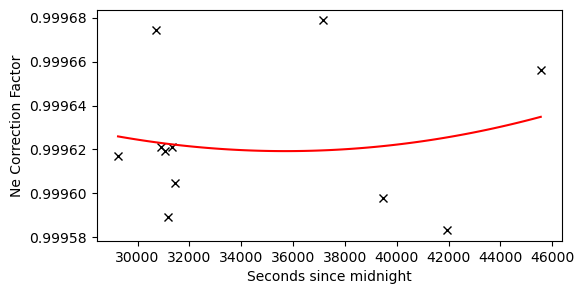

In [36]:
df_combo_filt=df_combo[density_test['Preferred D']>0]
model, fig=pf.reg_Ne_lines_time(df=df_combo_filt, N_poly=2, fit='poly')

## SAving as pickle, can then load as a pickle

In [37]:
import pickle
with open('Ne_Line_Regression_Example_cali.pck', 'wb') as file_handle:
    pickle.dump(model, file_handle)